# Catchment hydrological model

Let's start by creating a very simple hydrological model that estimates the daily outflow of from a catchment as a function of the daily rainfall falling on the catchment area. The catchment of study is covered by both urban and agricultural land and has a surface area **A = 500 ha**

![lumped model](images/Lumped_model.png).

The model consists of a single equation to estimate the daily outflow $Q$ (m3/day):

$Q = R * 0.001 * A * C$

where $R$ is the daily rainfall (mm/day), $A$ is the catchment area (m2) and $C$ is the unique model parameter and which is unitless (-)

The first thing, as always, is to import the Python libraries that we are going to need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact # to create interactive elements and figures

## Load data
We have **observed daily rainfall (mm/day), daily evapotranspiration (etp; mm/day) and outflow or runoff (m3/day) data from 2010 to 2019** in a Excel file that we are going to load and save as a variable called `obs_data`

In [2]:
obs_data = pd.read_excel('data/data example 2.xlsx',index_col = 'date')
obs_data # to print the data on screen

,rain,etp,outflow
date,,,
2010-01-01,2.032,1.168133,6531.84
2010-01-02,25.654,0.262242,6531.84
2010-01-03,13.462,0.991814,74995.20
2010-01-04,24.638,0.808446,33868.80
2010-01-05,0.000,0.849716,101606.40
...,...,...,...
2019-12-28,0.000,0.200841,9918.72
2019-12-29,0.000,0.738878,8951.04
2019-12-30,0.000,0.848909,8467.20


Let's **plot the observed rainfall rate** of one specific year, for example **2018**

Text(0.5, 1.0, 'Hyetograph (daily rainfall)')

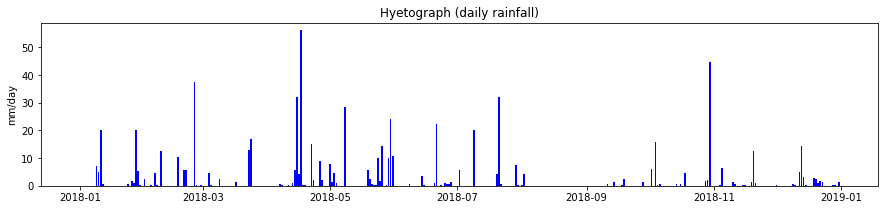

In [3]:
year_of_study = 2018
obs_data_year = obs_data[(obs_data.index.year == year_of_study)] # to select only data from to the year that we want to study
plt.figure(figsize=(15,3)) # to define the plot size
plt.bar(obs_data_year.index, obs_data_year['rain'], color = 'blue')
plt.ylabel('mm/day')
plt.title('Hyetograph (daily rainfall)')

And the **observed runoff rate** of **2018**

Text(0.5, 1.0, 'Observed hydrograph (daily flow)')

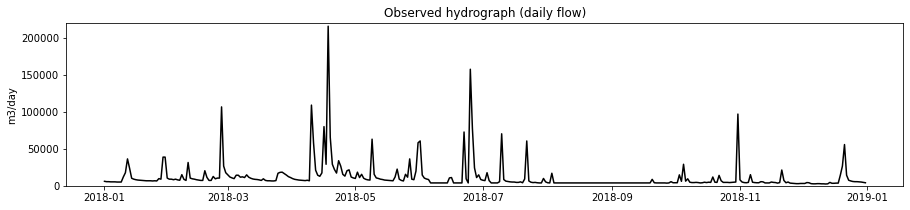

In [4]:
plt.figure(figsize=(15,3)) # to define the plot size
plt.plot(obs_data_year.index, obs_data_year['outflow'], color = 'black', label = 'observed')
plt.ylabel('m3/day')
plt.ylim([0,220000])
plt.title('Observed hydrograph (daily flow)')

Now, let's create our **model**. For this purpose we define a function called *hydro_model*

In [5]:
def hydro_model_1p(R, A, C):
    """
    Simple hydrological model to estimate the catchment outflow (Q).

    Parameters:
    R (float): Rainfall in millimeters (mm).
    A (float): Catchment area in square meters (m²).
    C (float): Runoff coefficient (dimensionless), representing the fraction of rainfall that becomes runoff.

    Returns:
    float: Catchment outflow (Q) in cubic meters (m³).
    """
    # Convert rainfall from millimeters to meters and calculate outflow
    Q = R * 0.001 * A * C  # 0.001 transforms mm into meters for unit consistency.
    
    return Q

We run the model we have just created by calling the function and defining the inputs and compare it visually with the observed catchment outflow

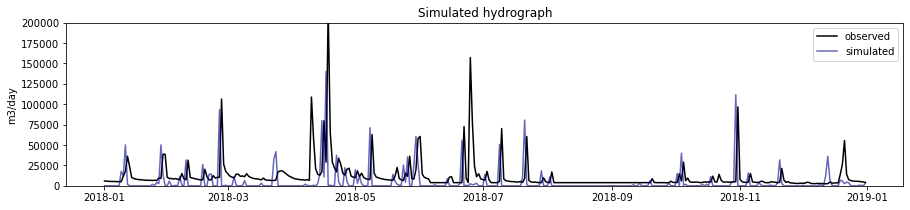

In [6]:
# Inputs
A = 500 * 10000 # ha to m2
C = 0.5
# Create an empty dataframe where we will save the model results
sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
sim_data_year['rain'] = obs_data_year['rain']
# Run the model
sim_data_year['outflow'] = hydro_model_1p(sim_data_year['rain'], A, C)
# Plot the simulated hydrograph
plt.figure(figsize=(15,3)) # to define the plot size
plt.plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',label = 'observed')
plt.plot(sim_data_year.index, sim_data_year['outflow'], color = 'darkblue', label = 'simulated', alpha = 0.6)
plt.ylabel('m3/day')
plt.ylim([0,200000])
plt.title('Simulated hydrograph')
plt.legend()

## Goodness-of-fit
To measure if the simulated values with a model are close to the observed data values we use googness-of-fit indicators. We are going to see two: the root mean squared error and the Nash-Sutcliffe efficiency

### Root mean squared error (RMSE)
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance. It has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response. 

$RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}$

### Nash-Sutcliffe efficiency (NSE)
The NSE indicates how well the plot of observed versus simulated data fits the 1:1 line. Nash-Sutcliffe efficiencies range from -Inf to 1. Essentially, the closer to 1, the more accurate the model is. -) NSE = 1, corresponds to a perfect match of modelled to the observed data.

Let's create two functions to compute RMSE and NSE

$NSE = 1 - \frac{\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}{\sum_{i=1}^{n}(obs_{i} - \overline{obs})^{2}}$

In [7]:
def RMSE_function(obs,sim):
    
    RMSE = np.sqrt(((sim - obs) ** 2).mean())
    return RMSE

def NSE_function(obs,sim):
    NSE = (1 - (sum((sim - obs) ** 2) / sum((obs - np.mean(obs))**2)))
    
    return NSE

RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])

### Calibration of the hydrological model
A hydrological model usually has a large number of parameters. The user is the one who decides the value of these parameters for a particular application based on the information and data we have about the parameters. Normally we will not have direct measurements of the values of these parameters, but it is likely that we will have historical climatic data and river flow (historical hydrograph of the river). With these data we can infer the values of the parameters by finding the values that make the model result better fit the historical hydrograph of the river, this is called **calibration** of the model.

### Understanding the Runoff Coefficient (C)

The **runoff coefficient** represents the fraction of rainfall that becomes surface runoff. It is a dimensionless parameter that varies between 0 and 1, where:
- **C = 0**: No runoff occurs (all rainfall infiltrates)
- **C = 1**: All rainfall becomes runoff (completely impervious surface)

The runoff coefficient depends on several factors:
- **Land use and cover**: Urban areas with impervious surfaces have higher values (0.70-0.95), while forested areas have lower values (0.05-0.25)
- **Soil type**: Sandy soils promote infiltration (lower C), while clayey soils promote runoff (higher C)
- **Slope**: Steeper slopes generally lead to higher runoff coefficients
- **Antecedent moisture conditions**: Wet soils produce more runoff than dry soils


In [8]:
@interact(C = (0,1,0.05))
def interactive_figure_1(C = 0):

    obs_data_year = obs_data[(obs_data.index.year == 2018)] # to select only data from to the year that we want to study
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model_1p(sim_data_year['rain'], A, C)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,6),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',label = 'observed')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'simulated', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,220000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), Output()), _dom_classes=('w…

Try to calibrate the model. The easiest way to do this is to change the parameter values one at a time and see how this changes the model output and how well it fits the historical hydrograph. Then answer these questions:

### Questions (EXPLAIN your answers)
- Is this a good hydrological model? why?
- Does it represent the main hydrological processes that take place in the catchment?
- What does the parameter C represents?
- Would you define this model as a black-box model or a conceptual model?
- What is the best value of C? and why?
- Which goodness-of-fit coefficient is better, RMSE or NSE?

### Let's have a closer look at the model performance
Now we plot the results against the obervations for only two months: January and February. Again, try to find the best model calibration by playing with the C value.

In [9]:
@interact(C = (0,1,0.05))
def interactive_figure_2(C = 0):

    obs_data_year = obs_data[(obs_data.index.year == 2018) & (obs_data.index.month < 3)]
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model_1p(sim_data_year['rain'], A, C)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,6),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',label = 'observed')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'simulated', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,220000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), Output()), _dom_classes=('w…

### Questions
- What are the main errors/limitations of the model when trying to simulate to the observations?

## Improved Two-Parameter Model with Lag Time

### Understanding Concentration Time and Lag Time

**Concentration time (Tc)** is the time required for runoff to travel from the most hydraulically remote point in the watershed to the outlet. **Lag time** represents the time interval between the center of mass or the peak of rainfall and the peak discharge response.

This delay occurs because:
- Water must travel across the catchment surface to reach channels
- Flow routing through the drainage network takes time
- Different flow paths have varying travel times

### Two-Parameter Model Implementation

The improved model incorporates a **time concentration parameter** to account for the delayed response of the catchment to rainfall events:


In [10]:
def hydro_model_2p(R, A, C, Tc):
    """
    Improved hydrological model with concentration time delay.
    Parameters:
    R (array-like): Rainfall (mm), 1D array over time steps.
    A (float): Catchment area (m²).
    C (float): Runoff coefficient (dimensionless).
    Tc (int): Concentration time in time steps (e.g., days).
    Returns:
    np.ndarray: Catchment outflow (Q) as an array over time steps (m³).
    """

    # Calculate outflow
    Q = R * A * C * 0.001

    # Apply concentration time (runoff output is lagged by Tc time steps)
    if Tc>0:
        Q_delayed = np.zeros_like(Q)
        Q_delayed[Tc:] = Q[:-Tc]
    else:
        Q_delayed = Q

    return Q_delayed

### Interactive Calibration with Lag Time

This interactive widget allows you to calibrate both the runoff coefficient (C) and the lag time simultaneously. Notice how adding lag time improves the temporal alignment between simulated and observed hydrographs:


In [11]:
def interactive_figure_2(C = 0, Tc= 0):

    obs_data_year = obs_data[(obs_data.index.year == 2018)] # to select only data from to the year that we want to study
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model_2p(sim_data_year['rain'], A, C, Tc)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,6),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',linestyle = '--',label = 'observed')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'simulated', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,220000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()
    
interact(interactive_figure_2, C = (0,1,0.05), Tc = (0,5))

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), IntSlider(value=0, descript…

<function __main__.interactive_figure_2(C=0, Tc=0)>

## Advanced Three-Parameter Model with Baseflow

### Understanding Baseflow

**Baseflow** represents the portion of streamflow that is not directly generated from rainfall during storm events. It consists of:

1. **Groundwater discharge**: Water from aquifers that provides sustained flow during dry periods
2. **Subsurface flow**: Slower lateral flow through soil layers
3. **Delayed contributions**: Water stored temporarily in soil and released gradually

Baseflow characteristics:
- Provides continuous flow even during dry periods
- Reaches peak after surface runoff peaks due to storage and routing effects
- Follows exponential recession curves
- Maintains water quality by providing cooler, more chemically stable water

### Three-Parameter Model with Baseflow

The most complete model includes a constant **baseflow component** to represent groundwater contributions and sustained low flows:


In [12]:
def hydro_model_3p(R, A, C, Tc, Qb):
    """
    Improved hydrological model with concentration time delay.
    Parameters:
    R (array-like): Rainfall (mm), 1D array over time steps.
    A (float): Catchment area (m²).
    C (float): Runoff coefficient (dimensionless).
    Tc (int): Concentration time in time steps (e.g., days).
    Qb (float): Constant baseflow (m³) 
    Returns:
    np.ndarray: Delayed catchment outflow (Q_delayed) as an array over time steps (m³).
    """
    
    # Calculate raw outflow (runoff + baseflow)
    Q = R * A * C * 0.001 + Qb

    # Apply concentration time (runoff output is lagged by Tc time steps)
    if Tc>0:
        Q_delayed = np.zeros_like(Q)
        Q_delayed[Tc:] = Q[:-Tc]
    else:
        Q_delayed = Q

    return Q_delayed

### Complete Model Calibration

This final interactive widget allows calibration of all three parameters: runoff coefficient (C), lag time, and baseflow. The baseflow parameter is particularly important for matching the continuous low flows observed during dry periods:

**Parameter interpretation:**
- **C (0-1)**: Fraction of rainfall becoming quick surface runoff
- **lag_time (0-5 days)**: Delay between rainfall and peak discharge response
- **baseflow (0-20,000 m³/day)**: Constant groundwater contribution maintaining base river flows


In [17]:
def interactive_figure_3(C = 0, Tc = 0, Qb = 0, year_of_study = 2018):

    obs_data_year = obs_data[(obs_data.index.year == year_of_study)] # to select only data from to the year that we want to study
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model_3p(sim_data_year['rain'], A, C, Tc, Qb)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,6),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black',linestyle = '--', label = 'observed')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'simulated', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,220000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()

interact(interactive_figure_3, C = (0,1,0.05), Tc = (0,5), Qb = (0,20000,1000), year_of_study = range(2010,2020))

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), IntSlider(value=0, descript…

<function __main__.interactive_figure_3(C=0, Tc=0, Qb=0, year_of_study=2018)>

## Model Evolution Summary

The progression from simple to complex models demonstrates key hydrological concepts:

1. **One-parameter model**: Basic rainfall-runoff relationship with instantaneous response
2. **Two-parameter model**: Adds time delays through concentration/lag time
3. **Three-parameter model**: Incorporates constant baseflow

### Advanced Discussion Questions

- Why are concentration time and baseflow essential for representing natural catchment behavior?
- For the year 2018, did you obtain a good calibration? why? What parameter values did you use?
- Now for 2013, using the same parameter values calibrated for the year 2018, do you obtain a good model calibration? Why?
- Did you obtain a better model calibration as more parameters were incorporated into the model?
- Does the model still have limitations? If so, what are the main errors/limitations of the model when trying to simulate to the observations?
- Why some observed flow peaks are not represented by the model? and why some simulated runoff peaks were not present in the observed flow?
- How would you further improve the model? 
- Can we improve the representation of baseflow? if so, how?

In [14]:
def hydro_model_3p_v2(R, A, C, lag_time, k):
    """
    Improved hydrological model with concentration time delay using: 
    - a constant value for the runoff
    - and the linear reservoir model for the baseflow
    Parameters:
    R (array-like): Rainfall (mm), 1D array over time steps.
    A (float): Catchment area (m²).
    C (float): Runoff coefficient (dimensionless).
    lag_time (int): Runoff concentration time lag in time steps (e.g., days).
    k (float): reservoir coefficient (units of 1/time).
    Returns:
    np.ndarray: Catchment outflow (Q) as an array over time steps (m³).
    """
    
    # Calculate raw runoff
    Q_raw = R * A * C * 0.001
    
    # Apply concentration time (runoff output is lagged by lag_time steps)
    if lag_time>0:
        Q_runoff = np.zeros_like(Q_raw)
        Q_runoff[lag_time:] = Q_raw[:-lag_time]
        # For lag_time > len(R), Q stays all zeros
    else:
        Q_runoff = Q_raw
    
    n_steps = len(R)
    Q_baseflow = np.zeros(n_steps)
    S = np.zeros(n_steps+1)
    
    for t in np.arange(n_steps):
        if t == 0:
            S[t] = 0
        else:
            Q_baseflow[t] =  S[t-1] / k
            S[t] = S[t-1] + R[t] * A * (1 - C) * 0.001 - Q_baseflow[t]
        
    Q = Q_runoff + Q_baseflow
        
    return Q

In [16]:
def interactive_figure_4(C = 0, lag_time = 0, k = 1):

    obs_data_year = obs_data[(obs_data.index.year == 2018)] # to select only data from to the year that we want to study
    
    # Create an empty dataframe where we will save the model results
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    # Run the model
    sim_data_year['outflow'] = hydro_model_3p_v2(sim_data_year['rain'], A, C, lag_time, k)

    RMSE = RMSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    NSE  = NSE_function(obs_data_year['outflow'],sim_data_year['outflow'])
    
    fig, ax = plt.subplots(2,1,figsize=(15,6),sharex = True)
    ax[0].bar(obs_data_year.index,obs_data_year['rain'],color = 'blue',label = 'rain')
    ax[0].set(ylabel='mm/day')
    ax[0].legend()
    ax[1].plot(obs_data_year.index,obs_data_year['outflow'],color = 'black', linestyle = '--', label = 'observed')
    ax[1].plot(sim_data_year.index,sim_data_year['outflow'],color = 'darkblue', label = 'simulated', alpha = 0.6)
    ax[1].set(ylabel='m3/day', ylim = [0,220000])
    ax[1].set_title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,2)))
    ax[1].legend()

interact(interactive_figure_4, C = (0,1,0.05), lag_time = (0,5), k = (1,10,1))

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0, step=0.05), IntSlider(value=0, descript…

<function __main__.interactive_figure_4(C=0, lag_time=0, k=1)>

 - What happens when lag_time and k are both equal to 1? How does the hydrograph change with C?